<a href="https://colab.research.google.com/github/leejunho12316/P-Project-Machine-Learning/blob/main/processPattern_%EB%B6%84%EB%A5%98_%EB%8B%A4%EC%A4%91_%ED%81%B4%EB%9E%98%EC%8A%A4_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 시작
패키지 install, 함수 정의

https://wikidocs.net/192931


In [1]:
pip install jpype1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 4.1 MB/s eta 0:00:00


In [2]:
pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 70.7 MB/s eta 0:00:00


In [3]:
pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.8 MB/s eta 0:00:00


In [4]:
#한글파일 unzip시 깨짐 encoding decoding으로 방지하는 함수, num개만 압축해제
def unzip(source_path, dest_path):
  with zipfile.ZipFile(source_path, 'r') as zf:
    zipInfo = zf.infolist()
    for member in zipInfo:
      try:
        #print(member.filename.encode('cp437').decode('euc-kr','ignore'))
        member.filename = member.filename.encode('cp437').decode('euc-kr','ignore')
        zf.extract(member,dest_path)
      except:
        print(source_path)
        raise Exception('??')

## 데이터 준비
데이터 다운로드

In [5]:
from google.colab import drive
import shutil
import zipfile
import os

import json

In [6]:
drive.mount('/content/drive')

source_path = '/content/drive/MyDrive/ML_Data/146.낚시성 기사 탐지 데이터.zip'
destination_path = '/content/146.낚시성 기사 탐지 데이터.zip'
shutil.copyfile(source_path,destination_path)

Mounted at /content/drive


'/content/146.낚시성 기사 탐지 데이터.zip'

## Data 다운로드/압축해제
원문 Clickbait Direct 만 뽑아 새로운 데이터셋 생성 - 본문/제목 다중입력

In [7]:
#데이터 저장을 위한 경로 만들기
root_path = '/content/root'
training_data_path = os.path.join(root_path,'Training')
test_data_path = os.path.join(root_path,'Test')

p = [root_path,training_data_path,test_data_path]
for i in p:
  if not os.path.exists(i):
    os.mkdir(i)

In [8]:
#전체 중 Clickbait_Direct 아닌거 삭제 - Clickbait_Direct 만 processPattern 가짐
unzip('/content/146.낚시성 기사 탐지 데이터.zip','/content')
raw_data_path = '/content/146.낚시성 기사 탐지 데이터'

for root,dirs,files in os.walk(raw_data_path):
  for fn in files:
    if 'Clickbait_Direct' not in fn or 'IS' in fn or 'LC' in fn or 'PO' in fn or 'SO' in fn or 'GB' in fn:
      os.remove(root+'/'+fn)



In [9]:
#전체데이터 zip 풀어dataset 만들기
for root,dirs,files in os.walk('/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/02.라벨링데이터'):
  for fn in files:
    unzip(root+'/'+fn,training_data_path)
for root,dirs,files in os.walk('/content/146.낚시성 기사 탐지 데이터/01.데이터/Validation/02.라벨링데이터'):
  for fn in files:
    unzip(root+'/'+fn, test_data_path)

#(임시) zip 하나만 풀어서 dataset 만들기
#a='/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/02.라벨링데이터/TL_Part1_Clickbait_Direct_EC.zip'
#b='/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/02.라벨링데이터/TL_Part1_Clickbait_Direct_IS.zip'
#unzip(a,training_data_path)
#unzip(b,test_data_path)

In [10]:
a = '/content/root/Training'
for root,dirs,files in os.walk(a):
  print(len(files))

22229


## 데이터 전처리

본문->토큰화->벡터화(원-핫 인코딩)

1.   train_data
[본문.........],[본문..........]....
2.   token_train_data
[시퀀스시퀀스시퀀스],[시퀀스시퀀스시퀀스],[시퀀스시퀀스시퀀스]....
3. x_train
[0,0,0,0,1,0,0,,,,],[0,1,0,0,0,0,,,,,,],,,,,



데이터준비

In [11]:
import re
import numpy as np

#training_data 경로의 모든 파일 읽어오기 (json)
training_files = []
for root, dirs, files in os.walk(training_data_path):
  for fn in files:
    training_files.append(root+'/'+fn)


#각 json 파일의 본문을 리스트에 추가
train_data_title = []#np.array([])
train_data = []#np.array([])
train_labels = []

for i in training_files:
  with open(i,'r',encoding='utf-8') as file:
    data = json.load(file)

    #제목
    newsTitle = data.get('sourceDataInfo').get('newsTitle')
    newsTitle = re.sub('[()]',' ',newsTitle)
    newsTitle = re.sub(r'\\',' ',newsTitle)
    train_data_title.append(newsTitle) #train_data_title = np.append(newsTitle, train_data_title)
    #본문
    newsContent = data.get('sourceDataInfo').get('newsContent')
    #newsContent = re.sub(r'\n',' ', newsContent) # 엔터키를 없애버리면 sentencepiece 패키지가 멍청해서 인식을 못함
    newsContent = re.sub('[()]',' ',newsContent)
    newsContent = re.sub(r'\\',' ',newsContent)
    train_data.append(newsContent) #train_data = np.append(newsContent,train_data)
    #라벨
    train_labels.append(int(data.get('sourceDataInfo').get('processPattern')))

#-------------------------------------------------------------------------
#위에랑 똑같은거 test에도
test_files = []
for root,dirs,files in os.walk(test_data_path):
  for fn in files:
    test_files.append(root+'/'+fn)

test_data = []#np.array([])
test_data_title = []#np.array([])
test_labels = []

for i in test_files:
  with open(i,'r',encoding = 'utf-8') as file:
    data = json.load(file)

    #제목
    newsTitle = data.get('sourceDataInfo').get('newsTitle')
    newsTitle = re.sub('[()]',' ',newsTitle)
    newsTitle = re.sub(r'\\',' ',newsTitle)
    test_data_title.append(newsTitle) #test_data_title = np.append(newsTitle, test_data_title)

    newsContent = data.get('sourceDataInfo').get('newsContent')
    newsContent = re.sub('[()]',' ',newsContent)
    newsContent = re.sub(r'\\',' ',newsContent)
    test_data.append(newsContent) #test_data = np.append(newsContent,test_data)

    test_labels.append(int(data.get('sourceDataInfo').get('processPattern')))

본문 - 토큰화

In [12]:
#한국어 토큰화 위한 과정
#https://velog.io/@lighthouse97/%ED%85%8D%EC%8A%A4%ED%8A%B8-%EC%A0%84%EC%B2%98%EB%A6%AC-%ED%86%A0%ED%81%B0%ED%99%94

#토큰화 - 1 형태소 분석
from konlpy.tag import Okt

okt = Okt()
text = '아이고 배고파 ㅠㅠ 이럴수가. 컵라면을 사먹어요'

morphs = okt.morphs(text)
ps = okt.pos(text)
noun = okt.nouns(text)
print(f"형태소 분석 : {morphs}")
print(f'품사 태깅 : {ps}')
print(f'명사 추출 : {noun}')

형태소 분석 : ['아이고', '배고파', 'ㅠㅠ', '이럴수가', '.', '컵라면', '을', '사먹어요']
품사 태깅 : [('아이고', 'Exclamation'), ('배고파', 'Adjective'), ('ㅠㅠ', 'KoreanParticle'), ('이럴수가', 'Adjective'), ('.', 'Punctuation'), ('컵라면', 'Noun'), ('을', 'Josa'), ('사먹어요', 'Verb')]
명사 추출 : ['컵라면']


**메모리 조정 코너**

In [13]:
#vocab_size (30000개 : 메모리 넘침)
vocab_size = 10000

In [14]:
#토큰화 - 2 Subword Tokenizer
#BPE 알고리즘을 구현한 구글의 Sentencepiece를 사용해 내부 단어 분리 진행

#이름.model 이 sentencepiece에서 사용되는 단어집합
#이름.vocal 이 단어 집합을 텍스트 파일로 저장한것
#모든 텍스트파일을 하나의 txt에 쳐넣고 학습해 model을 만들고 각각의 train_data 안에 있는 데이터에 sp.encode를 해주면 된다.

import sentencepiece as spm

#모든 텍스트 하나의 txt에 쳐넣어 sentencepiece 학습시키기
with open('/content/test1.txt','w',encoding='utf-8') as f:
  for i in range(0,len(train_data)):
    f.write(train_data[i])
  for i in range(0,len(test_data)):
    f.write(test_data[i])
  f.close()

spm.SentencePieceTrainer.Train(f'--input=test1.txt --model_prefix=mine --vocab_size={vocab_size} --model_type=bpe --max_sentence_length=9999')

#Sentence piece 객체 생성
sp = spm.SentencePieceProcessor()



In [15]:
#모델 불러와 인코딩, 디코딩 시험
sp.load('mine.model')
print(sp.encode(train_data[0], out_type=int))
#print(sp.DecodeIds([13702, 353, 7004, 394, 497, 930, 18833, 2368, 364, 2985, 1484, 1977, 19050, 1742, 167, 3834, 5689, 18747, 1587, 105, 18992, 19310, 19131, 18907, 1880]))


[1574, 8693, 458, 1805, 6260, 1044, 8612, 3087, 1418, 1805, 3645, 8612, 5501, 97, 8617, 1181, 1269, 1686, 2838, 8612, 3418, 68, 8610, 241, 8689, 1730, 6, 9028, 1964, 1093, 6072, 4710, 2187, 27, 8695, 8862, 9386, 8657, 1805, 483, 527, 146, 515, 8615, 1805, 6260, 9605, 97, 8617, 1301, 2164, 8610, 739, 708, 423, 689, 8609, 8610, 82, 9082, 2600, 97, 8617, 8636, 160, 27, 8849, 8840, 8875, 1261, 27, 8634, 8634, 8657, 8617, 395, 33, 869, 8644, 8700, 2522, 128, 2644, 19, 1805, 8980, 4020, 3645, 8612, 5683, 892, 8630, 611, 469, 8623, 4710, 8868, 70, 9028, 95, 9654, 8650, 1587, 1093, 6072, 8545, 1805, 1226, 8665, 3347, 2597, 3328, 235, 8998, 22, 8610, 2686, 4891, 257, 3375, 8770, 5778, 1204, 1044, 48, 8777, 8611, 739, 708, 1044, 3644, 86, 151, 870, 8610, 2573, 12, 527, 2701, 86, 818, 2409, 8613, 4383, 1181, 1839, 698, 68, 8610, 27, 8654, 8642, 1261, 27, 8614, 8695, 8868, 1261, 27, 9590, 8956, 1726, 1261, 27, 8615, 8617, 8805, 8642, 1261, 27, 8614, 1657, 8657, 626, 395, 68, 8610, 241, 8689, 112, 

In [16]:
#train_data, test_data 전부 Tokenize
token_train_data = []
for i in range(0,len(train_data)):
  token_train_data.append(sp.encode(train_data[i], out_type = int))
token_test_data = []
for i in range(0,len(test_data))  :
  token_test_data.append(sp.encode(test_data[i],out_type=int))

#train_data_title, test_data_title 전부 Tokenize
token_train_data_title = []
for i in range(0,len(train_data_title)):
  token_train_data_title.append(sp.encode(train_data_title[i], out_type=int))
token_test_data_title = []
for i in range(0,len(test_data_title)):
  token_test_data_title.append(sp.encode(test_data_title[i], out_type=int))

본문 - 벡터변환 (원-핫 인코딩)

In [17]:
#데이터 벡터변환 (원-핫 인코딩 방식 벡터변환으로 각 기사에 어떤 단어가 사용되었는지에 대한 정보를 담고 있다.)
import numpy as np

#행 : 각 기사들, 열 : 단어 시퀀스, 값 : 기사의 해당 단어 사용 여부
def vectorize_squences(sequences, dimension=vocab_size): #dimension은 sentencepiece의 vocab_size 와 같게
  results = np.zeros((len(sequences),dimension))
  print(results.shape)

  #i번째 원소의 기사 sequence를 np.zero 각각의 줄에 그냥 다 넣기
  for i, sequence in enumerate(sequences):
    results[i,sequence] = 1
  return results

x_train = vectorize_squences(token_train_data)
x_test = vectorize_squences(token_test_data)
x_train_title = vectorize_squences(token_train_data_title)
x_test_title = vectorize_squences(token_test_data_title)

(22229, 10000)
(2776, 10000)
(22229, 10000)
(2776, 10000)


라벨->벡터변환(원 핫 인코딩)


1.   train_labels
[3,4,3,6,1,2,6,3,7,3....]
2.   one_hot_train_labels
[0,0,0,0,1,0,0,0],[0,0,0,0,0,0,0,1],[1,0,0,0,0,0,0,0]


라벨 값
*   0-5은 processPattern 11-16
*   6-9은 processPattern 21-24


In [18]:
#라벨 원-핫 인코딩 벡터변환
def to_one_hot(labels, dimension=10):
  results = np.zeros((len(labels),dimension))
  for i, label in enumerate(labels):
    if label <= 16:
      results[i,label-11] = 1
    elif label >=21:
      results[i,label-15] = 1
    else:
      pass
  return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [19]:
print(one_hot_train_labels)
print(one_hot_test_labels)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


## 3.모델 만들기


입력 Layer 2개- 본문/제목
은닉 Layer
출력 Layer 10개


In [20]:
#데이터 train:validation
num1 = len(x_train)//10*4
num2 = len(x_train_title)//10*4
num3 = len(one_hot_train_labels)//10*4

#본문 x_val/partial_x_train
x_val = x_train[:num1]
partial_x_train = x_train[num1:]

#제목 x_val_title/partial_x_train_title
x_val_title = x_train_title[:num2]
partial_x_train_title = x_train_title[num2:]

#test y_val/partial_y_train
y_val = one_hot_train_labels[:num3]
partial_y_train = one_hot_train_labels[num3:]



In [21]:
print(num1, num2, num3)

8888 8888 8888


## 4. 모델 구성
출력 클래스 개수 10개

In [22]:
#######################################################################다중입력 모델 만들어보기
import keras
import tensorflow
from keras import models
from keras import layers
from keras.preprocessing.sequence import pad_sequences



#본문, 타이틀 input
title_input = keras.Input(shape=(vocab_size,), name = 'title') #shape=(5000,) 은 1차원 배열 5000개를 받는다는 뜻
content_input = keras.Input(shape=(vocab_size,), name = 'content')

x1 = layers.Dense(16, activation='relu')(title_input)
x1 = layers.Dropout(0.1)(x1) #과적합 방지
x1 = layers.Dense(16, activation='relu')(x1)

x2 = layers.Dense(16, activation='relu')(content_input)
x2 = layers.Dropout(0.1)(x2)
x2 = layers.Dense(16, activation='relu')(x2)

concatenated = keras.layers.concatenate([x1,x2])
concatenated = layers.Dropout(0.1)(concatenated)

output = layers.Dense(10, activation = 'softmax')(concatenated)

model = models.Model(inputs = [title_input, content_input], outputs = output)

model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

training accuracy 증가 & validation accuracy 감소 : 과대적합
training data라는 악기에만 적응하고 validation이라는 새로운 악기는 연주하지 못하게 되는 현상


1.   batch size 증가시켜 좁은 범위의 데이터에 집중하지 않도록 유도
2.   신경망 뉴런 개수 조절 : 뉴런 개수 줄여 과한 많은 학습을 하지 않도록 조절
3. 데이터 더 크게 : 학습할 데이터 수를 늘려 학습 데이터에만 적응하는 경우가 없도록 함
4. Dropout Layer : 특정 데이터에 의도적으로 학습을 중단해 골고루 학습할 수 있도록 함




In [23]:
history = model.fit([partial_x_train_title, partial_x_train],
                    partial_y_train, #모델이 예측해야 하는 타켓 클래스로, 마지막 Dense Layer의 출력층과 연결되어 있음
                    epochs=10,
                    batch_size=200,
                    validation_data=([x_val_title,x_val], y_val) )


Epoch 1/10
67/67 [==============================] - 12s 71ms/step - loss: 2.1397 - accuracy: 0.2290 - val_loss: 2.0745 - val_accuracy: 0.2429
Epoch 2/10
67/67 [==============================] - 2s 23ms/step - loss: 1.9791 - accuracy: 0.2843 - val_loss: 2.0362 - val_accuracy: 0.2667
Epoch 3/10
67/67 [==============================] - 2s 28ms/step - loss: 1.8150 - accuracy: 0.3625 - val_loss: 2.0262 - val_accuracy: 0.2745
Epoch 4/10
67/67 [==============================] - 2s 25ms/step - loss: 1.6351 - accuracy: 0.4453 - val_loss: 2.0370 - val_accuracy: 0.2605
Epoch 5/10
67/67 [==============================] - 3s 39ms/step - loss: 1.4548 - accuracy: 0.5168 - val_loss: 2.0892 - val_accuracy: 0.2611
Epoch 6/10
67/67 [==============================] - 1s 18ms/step - loss: 1.2799 - accuracy: 0.5805 - val_loss: 2.1966 - val_accuracy: 0.2637
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 1.1135 - accuracy: 0.6420 - val_loss: 2.3093 - val_accuracy: 0.2519
Epoch 8/10
6

모델 저장, 구조보기

In [ ]:
save_path = '/content/model'
if not os.path.exists(save_path):
  os.mkdir(save_path)
else:
  print('경로 있음')

model_name = 'processPattern_classificaton_model_ver1'
destination_path = os.path.join(save_path,model_name)

model.save(destination_path)


In [33]:
import zipfile

folder_path = '/content/model/processPattern_classificaton_model_ver1'
zip_path = '/content/drive/MyDrive/ML_model_backup/processPattern_classificaton_model_ver1.zip'

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
  for root, dirs, files in os.walk(folder_path):
    for file in files:
      file_path = os.path.join(root, file)
      arcname = os.path.relpath(file_path, folder_path)
      zipf.write(file_path, arcname = arcname)

모델 통계

In [ ]:
model.summary()

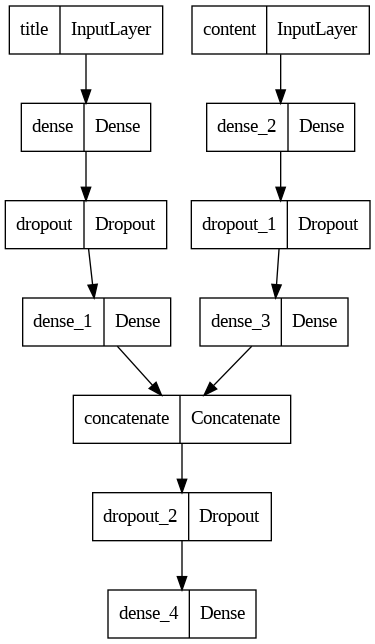

In [35]:
tensorflow.keras.utils.plot_model(model)

성능 그래프

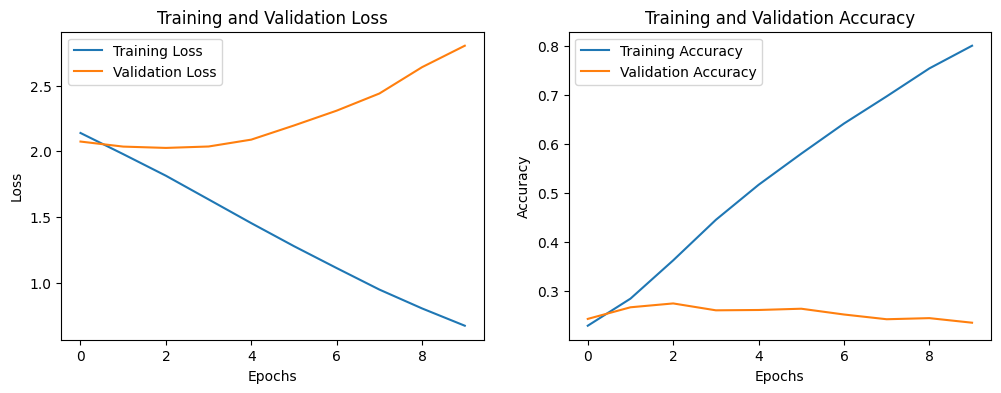

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 훈련 및 검증 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Confusion Matrix 그리기

In [26]:
from sklearn.metrics import confusion_matrix

# 예측 실행
y_pred = model.predict([x_val_title, x_val])

#정답 값
conf_y_true = []
for i in y_val:
  for index, value in enumerate(i):
        if value == 1:
            conf_y_true.append(index)

#예측 값
conf_y_pred = []
for i in y_pred:
  conf_y_pred.append(np.argmax(i))


#->matrix
#input -> x_val, x_val_title & y_val

278/278 [==============================] - 1s 4ms/step


In [27]:
# Confusion Matrix 생성
cm = confusion_matrix(conf_y_true, conf_y_pred)

# Confusion Matrix 출력
print(cm)

[[964 377  31  30  81   7  72  80 237 274]
 [436 290  29  24  44   4  38  36  90 112]
 [151  89   4   8  12   0  16  17  43  24]
 [184 112  11   8  25   2  24  17  63  58]
 [251  82   9  15  14   1  11  24  56  88]
 [110  53   6   3  10   0   8  13  24  43]
 [186  53   5   5  15   2  78 114 141 103]
 [187  43   8  11   9   1  88 122 143  58]
 [395 103  17  13  36   6 108 116 250 258]
 [419 108   7  10  31   7  76  61 190 360]]


([<matplotlib.axis.YTick at 0x7d6e8b4da290>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8'),
  Text(0, 9, '9')])

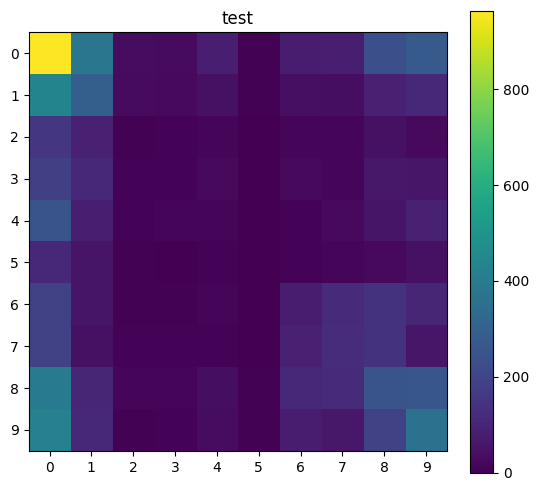

In [28]:
title = 'test'
cmap = plt.cm.viridis
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)  # , cmap=plt.cm.Greens

plt.title(title, size=12)
plt.colorbar(fraction=0.05, pad=0.05)
tick_marks = np.arange(3, 3)
plt.xticks(np.arange(10), ('0', '1', '2','3','4','5','6','7','8','9'))
plt.yticks(np.arange(10), ('0', '1', '2','3','4','5','6','7','8','9'))

## 모델 시연

새로운 데이터로 테스트해보기
본문->토큰화->벡터화->모델 분석 ->argmax 함수

In [29]:
title = '''[종합]'애벌레 사기' 김종민, '500억 자산설→현실은 전세'…그래도 '한강뷰'''

text = '''[스포츠조선 이정혁 기자]'500억 자산설' 김종민이 '애벌레 사기'로 전재산을 날린 뒤 전세로 마련한 집에서 촬영을 했다.


지난 9일 방송된 MBC '놀면 뭐하니?'에서는 음악방송을 앞둔 JS 엔터테인먼트 '원탑' 멤버들이 김종민의 기획사, '신바 엔터테인먼트'를 찾은 모습을 소개했다.

김종민은 1인 기획사 '신바 엔터테인먼트'의 유일한 소속 가수이자 대표다. JS 엔터테인먼트 멤버들이 방문한 '신바 엔터테인먼트' 사옥은 다름 아닌 김종민의 실제 집이었다.

JYP 구내식당에서 밥을 먹었던 것에 이어 멤버들은 신바 엔터테인먼트에서도 밥을 먹었고, 김종민은 '신지 어머니표 김치'로 대접을 했다.

"신지 어머니께서 직접 주셨다"고 밝힌 김종민은 "사실 우리 엄마도 했는데 망쳤다고 안 주셨다. 근데 신지 어머니께서 성공을 하셨다"고 설명했다.

이어 한강뷰 김종민의 집을 구경하던 하하는 "벽에 그림이나 스티커 같은 게 안 붙어있으니까 되게 신기하다"며 두리번거렸다. 이에 유재석은 "하하도 그렇고 저도 그렇고 아이들이 벽에 스티커를 많이 붙인다"며 "집이 너무 좋다"며 감탄사를 연발했다.

한편 지난 10월 방송된 SBS '미운 우리 새끼'에서는 김종민은 집에서 생일파티를 하면서 "이걸 왜 우리 집에서 하냐. 여기 자가도 아닌 전세"라고 불평했다.

이에 최진혁이 "왜 전세냐. 재산 500억원이 있다는 이야기는 뭐냐"고 묻자, 김종민은 "그건 다 루머"라며 "과거 사기를 많이 당했다. 미래에 대한 불안감 때문에 그런 일이 생겼던 것 같다"며 입을 열었다.

"미군 부대에 술을 납품하는 사업이 있다더라. 애벌레가 들어간 테킬라가 있는데 같이 납품하는 사업을 해보자고 제안한 사람이 있었다. 돈이 딱 몇천이 모자라다고 해 투자했다. 그게 내 전 재산이었다"고 사기 당했던 일을 떠올린 김종민은 "분명히 돈을 벌 수 있다고 해서 믿고 투자했다. 그런데 갑자기 연락이 끊겼고 그렇게 전 재산을 날렸다"고 했다.

이어 결국 그 돈을 받는데 실패했다고 밝혀, 안쓰러움을 더했다.'''


#토큰화->패딩->벡터화->입력
token_title = sp.encode(title,out_type= int)
token_text = sp.encode(text,out_type=int)


padded_title = pad_sequences([token_title], maxlen=500) #pad_sequences 는 리스트를 받기 때문에 []해줌
padded_text = pad_sequences([token_text], maxlen=500)

vec_title = vectorize_squences(padded_title)
vec_text = vectorize_squences(padded_text)

pred1 = model.predict([vec_title,vec_text])

np.argmax(pred1[0])

(1, 10000)
(1, 10000)
1/1 [==============================] - 0s 31ms/step


9

from keras import models
from keras import layers

#Sequential 모델 정의
model = models.Sequential()
#입력층 - 64개의 뉴런, relu 활성화 함수, 10000개의 입력데이터
model.add(layers.Dense(64, activation='relu',input_shape=(5000,)))
#은닉층
model.add(layers.Dense(64, activation='relu'))
#출력층
model.add(layers.Dense(10, activation='softmax'))


model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])